### Content

To improve the efficiency and reach of diagnostic services, the Radiological Society of North America (RSNA®) has reached out to Kaggle’s machine learning community and collaborated with the US National Institutes of Health, The Society of Thoracic Radiology, and MD.ai to develop a rich dataset for this challenge.

https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf


In [1]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image, ImageOps, ImageEnhance
import pydicom as dicom

In [2]:
database_path = '../../data/raw/rsna-pneumonia-detection-challenge/'

data = pd.read_csv(os.path.join(database_path, 'stage_2_train_labels.csv'))
data

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [3]:
data['Target'].value_counts(dropna=False)

0    20672
1     9555
Name: Target, dtype: int64

In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,9555.0,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,366.839560,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0


In [5]:
data['patientId'].nunique()

26684

In [6]:
data['patientId'].value_counts()

3239951b-6211-4290-b237-3d9ad17176db    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
                                       ..
7233ab9f-7fa6-4b5b-acdc-1c93bf945db5    1
722cca4a-f542-47ba-be14-29238c1124e1    1
722ad9c3-919a-4c08-bb67-cafd603ba754    1
7228bf11-3ce7-47f5-bee3-d36325df1dc8    1
943b27f1-ba1c-415b-b738-7b52aefa445b    1
Name: patientId, Length: 26684, dtype: int64

In [7]:
train_folder = os.path.join(database_path, 'stage_2_train_images')
test_folder = os.path.join(database_path, 'stage_2_test_images')

train_files = os.listdir(train_folder)
test_files = os.listdir(test_folder)

print(f"Train files: {len(train_files)} (labeled)")
print(f"Test files: {len(test_files)} (unlabeled)")

Train files: 26684 (labeled)
Test files: 3000 (unlabeled)


In [8]:
data.drop_duplicates('patientId')

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0


In [9]:
data['img_filepath'] = data['patientId'].apply(lambda x: os.path.join(train_folder, x + '.dcm').replace("\\", '/'))
data

,patientId,x,y,width,height,Target,img_filepath
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,../../data/raw/rsna-pneumonia-detection-challe...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,../../data/raw/rsna-pneumonia-detection-challe...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,../../data/raw/rsna-pneumonia-detection-challe...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,../../data/raw/rsna-pneumonia-detection-challe...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,../../data/raw/rsna-pneumonia-detection-challe...
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,../../data/raw/rsna-pneumonia-detection-challe...
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,../../data/raw/rsna-pneumonia-detection-challe...
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,../../data/raw/rsna-pneumonia-detection-challe...
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,../../data/raw/rsna-pneumonia-detection-challe...


In [10]:
filepath = '../../data/raw/rsna-pneumonia-detection-challenge/stage_2_train_images/3239951b-6211-4290-b237-3d9ad17176db.dcm'
ds = dicom.dcmread(filepath)

In [11]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2740.1517874298.197769
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2740.1517874298.197769
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

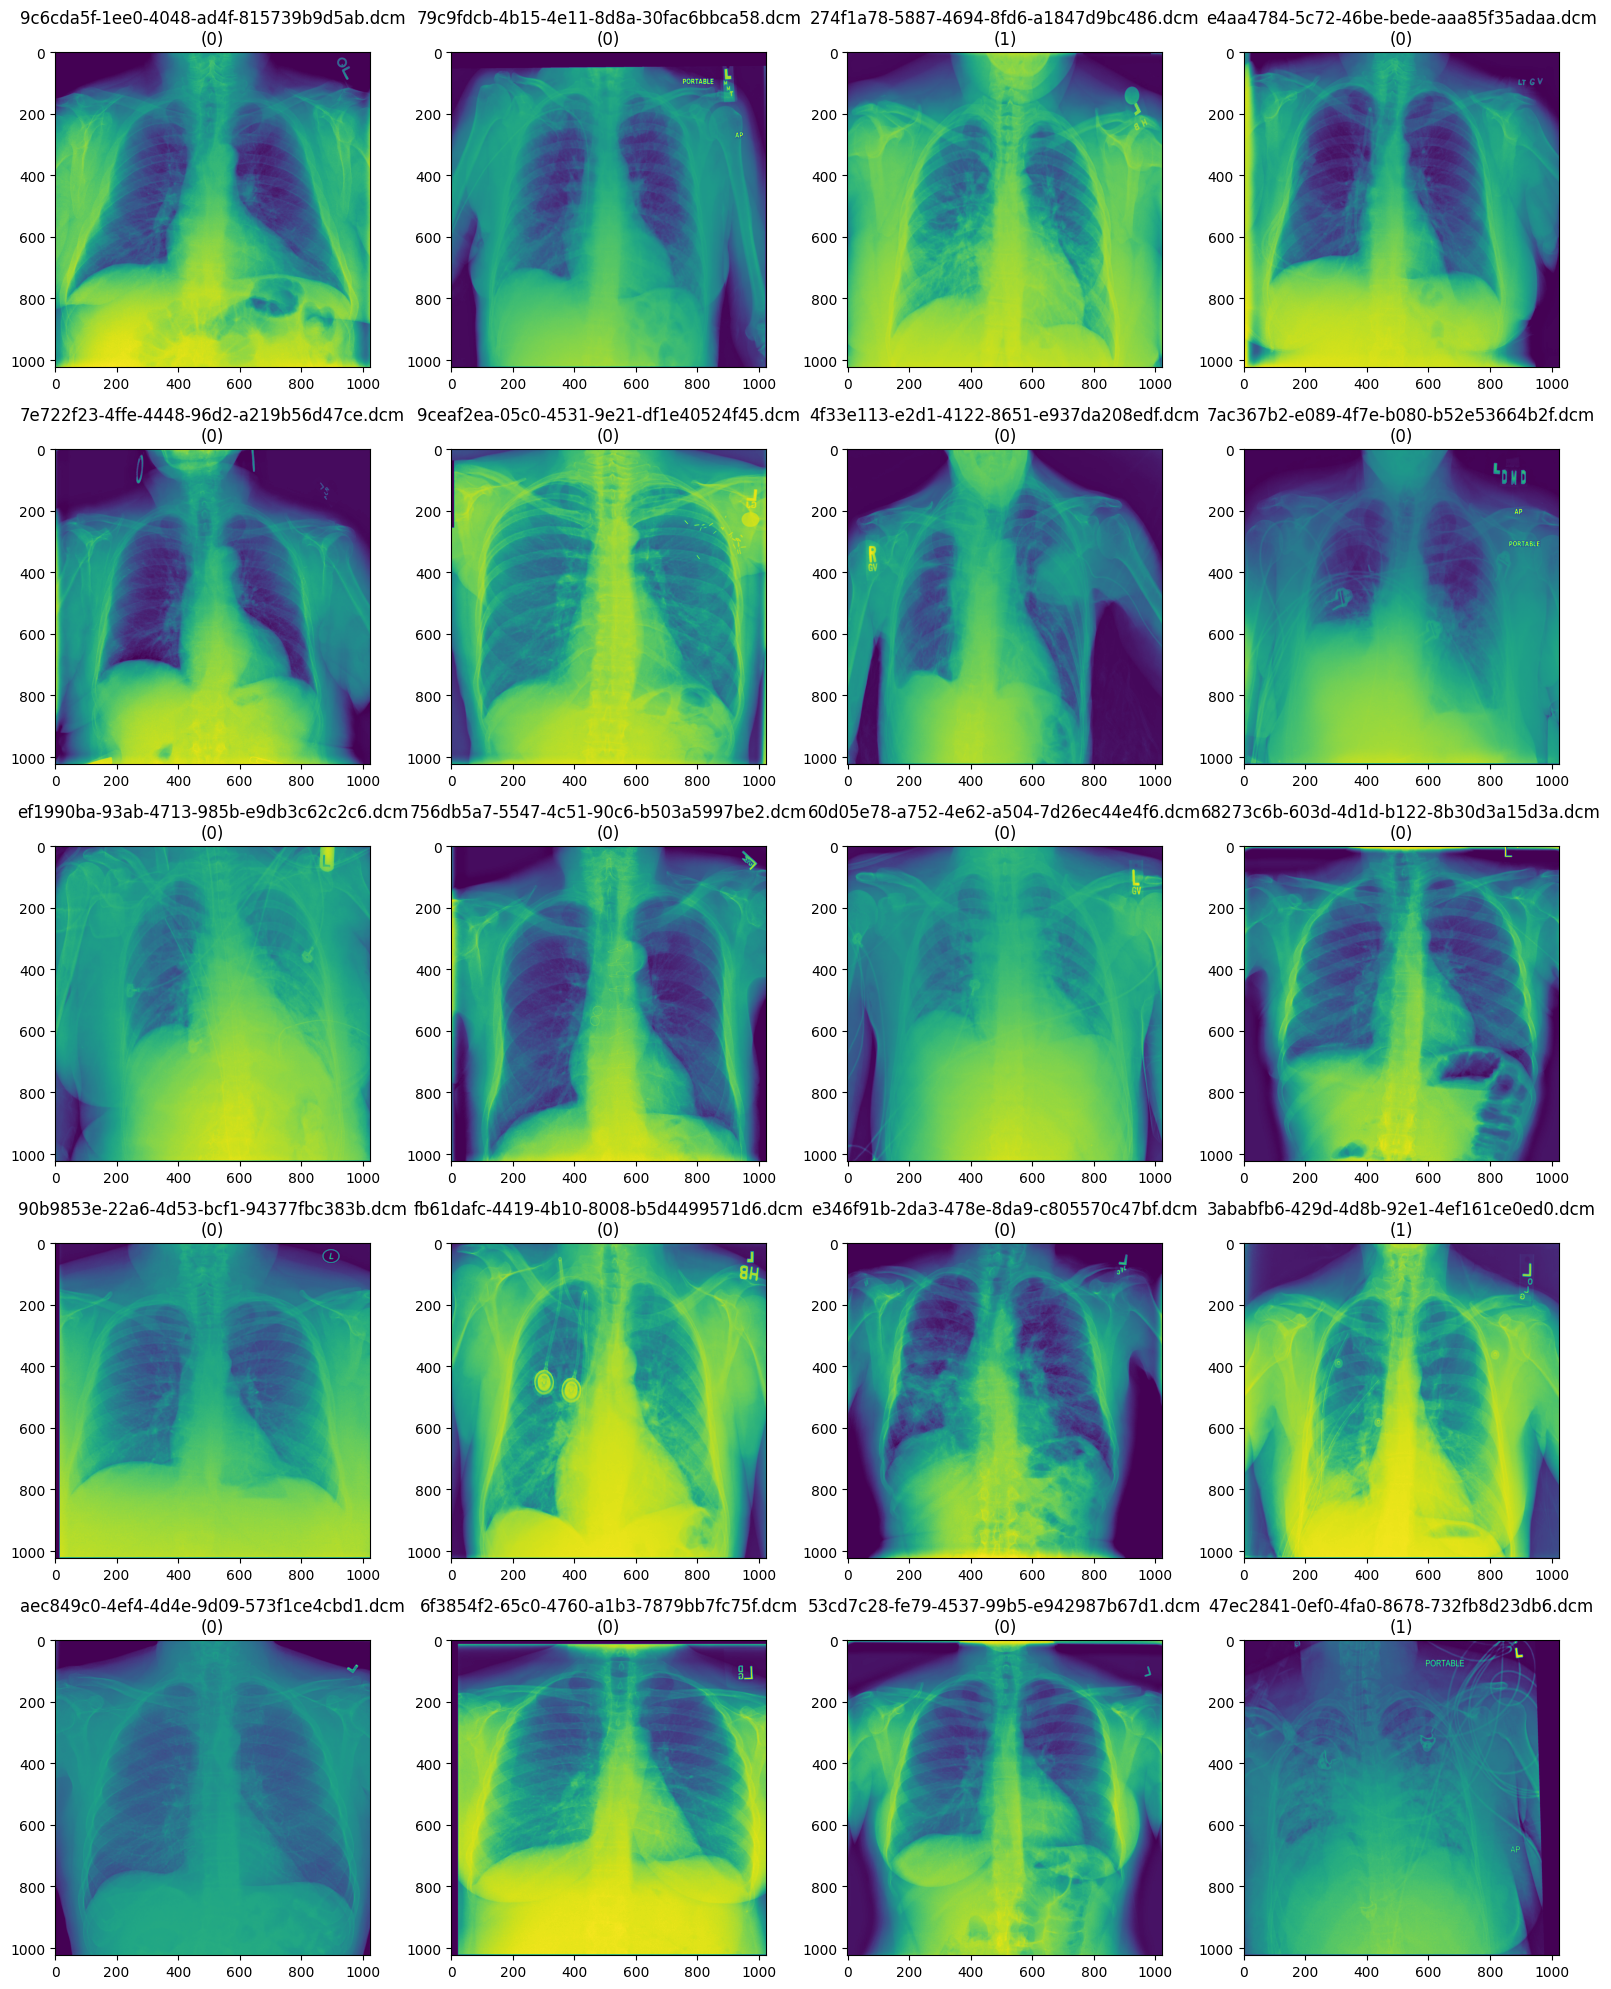

In [12]:
def plot_dicom_imgs_from_df(df, filepath_col, y_col, figsize=(16, 20), n_images=20, subplotshape=(5, 4)):
    # Plotting a sample of the original train images:
    plt.figure(figsize=figsize)
    for i in range(n_images):
        df_sample = df.sample()
        filepath = df_sample[filepath_col].values[0]
        ds = dicom.dcmread(filepath)

        # show the image
        plt.subplot(subplotshape[0], subplotshape[1], i+1)
        plt.title(f"{filepath.split('/')[-1]}\n({df_sample[y_col].values[0]})")
        plt.imshow(ds.pixel_array)

    plt.tight_layout()
    plt.show()
    
plot_dicom_imgs_from_df(data, filepath_col='img_filepath', y_col='Target')

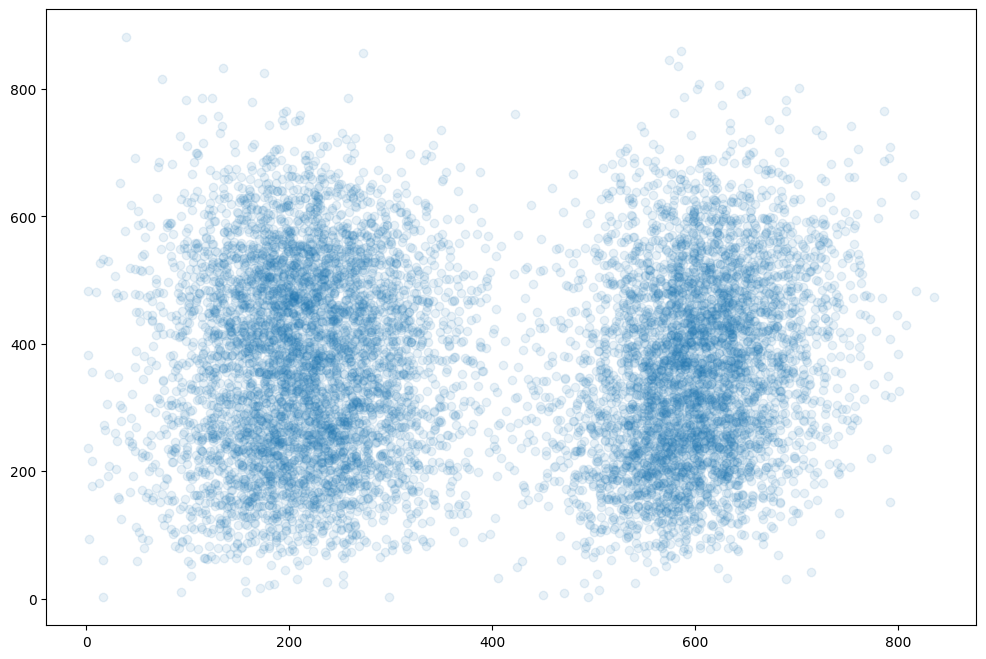

In [13]:
# Image size:
plt.figure(figsize=(12, 8))
plt.scatter(data['x'], data['y'], alpha=0.1)
plt.show()

### Conclusions

- Base de dados com imagens de diversos tamanhos.
- Total: 30227 imagens rotuladas
- Total: 26684 pacientes únicos
- Não cita a existência de diferentes protocolos para a geração das imagens, assumirei que todas seguem o mesmo protocolo.
